In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
print(tf.__version__)

2.10.0


In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/LSTM_DATA/text_labels_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/LSTM_DATA/text_labels_test.csv')

In [5]:
df_train.head()

,ID,tweet,label
0,865,Wednesday High pressure remains in charge yet ...,neutral
1,1706,The Dragon watching ... Beach Green Isolated ...,positive
2,3363,Via Reddit Final Fantasy IX Mistaken Love ReM...,positive
3,1346,Prayers JesusSaves NoOtherName Overcomer TeamJ...,positive
4,3188,USER so I have the new single on repeat and yo...,positive


In [6]:
df_test.head()

,ID,tweet,label
0,1669,Zoe's first love Rattled USER \n,positive
1,4571,Every time I see her dissing him I get so enra...,negative
2,1124,"He is compassionate, kind and forgiving. He ha...",negative
3,245,FAST FURIOUS 6 MOVIE COLLECTION DVD BOX SET V...,neutral
4,4614,Excited to kick off USER season by sharing ou...,positive


In [7]:
print(df_train.shape, df_test.shape)

(3711, 3) (464, 3)


In [8]:
df_train['label'].value_counts()

,count
label,
neutral,1396
positive,1354
negative,961


In [9]:
df_test['label'].value_counts()

,count
label,
neutral,175
positive,169
negative,120


In [ ]:
!pip install text_hammer

In [11]:
import text_hammer as th

In [12]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df, col_name):
  column = col_name
  df[column] = df[column].progress_apply(lambda x:str(x).lower())
  df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) # you're -> you are; we'll be -> we will be
  df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))

  df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))

  return df

CPU times: user 1.04 ms, sys: 51 µs, total: 1.09 ms
Wall time: 1.79 ms


In [13]:
data_train = text_preprocessing(df_train, 'tweet')
data_test = text_preprocessing(df_test, 'tweet')

  0%|          | 0/3711 [00:00<?, ?it/s]

  0%|          | 0/3711 [00:00<?, ?it/s]

  0%|          | 0/3711 [00:00<?, ?it/s]

  0%|          | 0/3711 [00:00<?, ?it/s]

  0%|          | 0/3711 [00:00<?, ?it/s]

  0%|          | 0/3711 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

In [14]:
data_train.head()

,ID,tweet,label
0,865,wednesday high pressure remains in charge yet ...,neutral
1,1706,the dragon watching beach green isolated morni...,positive
2,3363,via reddit final fantasy ix mistaken love remi...,positive
3,1346,prayers jesussaves noothername overcomer teamj...,positive
4,3188,user so i have the new single on repeat and yo...,positive


In [15]:
data_test.head()

,ID,tweet,label
0,1669,zoes first love rattled user,positive
1,4571,every time i see her dissing him i get so enra...,negative
2,1124,he is compassionate kind and forgiving he hate...,negative
3,245,fast furious 6 movie collection dvd box set va...,neutral
4,4614,excited to kick off user season by sharing our...,positive


In [16]:
data_train = data_train.iloc[:, 1:]
data_test = data_test.iloc[:, 1:]

In [17]:
data_train.head()

,tweet,label
0,wednesday high pressure remains in charge yet ...,neutral
1,the dragon watching beach green isolated morni...,positive
2,via reddit final fantasy ix mistaken love remi...,positive
3,prayers jesussaves noothername overcomer teamj...,positive
4,user so i have the new single on repeat and yo...,positive


In [18]:
data_test.head()

,tweet,label
0,zoes first love rattled user,positive
1,every time i see her dissing him i get so enra...,negative
2,he is compassionate kind and forgiving he hate...,negative
3,fast furious 6 movie collection dvd box set va...,neutral
4,excited to kick off user season by sharing our...,positive


In [19]:
data_train.replace({'label':{'positive': 0, 'negative': 1, 'neutral': 2}}, inplace=True)
data_test.replace({'label':{'positive': 0, 'negative': 1, 'neutral': 2}}, inplace=True)

In [20]:
data_train.head()

,tweet,label
0,wednesday high pressure remains in charge yet ...,2
1,the dragon watching beach green isolated morni...,0
2,via reddit final fantasy ix mistaken love remi...,0
3,prayers jesussaves noothername overcomer teamj...,0
4,user so i have the new single on repeat and yo...,0


In [21]:
data_test.head()

,tweet,label
0,zoes first love rattled user,0
1,every time i see her dissing him i get so enra...,1
2,he is compassionate kind and forgiving he hate...,1
3,fast furious 6 movie collection dvd box set va...,2
4,excited to kick off user season by sharing our...,0


In [22]:
print(data_train.shape, data_test.shape)

(3711, 2) (464, 2)


In [23]:
# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data_train['tweet'])
X_train = pad_sequences(tokenizer.texts_to_sequences(data_train['tweet']), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(data_test['tweet']), maxlen=200)

In [24]:
print(X_train)

[[   0    0    0 ...  105 1294  122]
 [   0    0    0 ...  526 1677  588]
 [   0    0    0 ...   15 2310 3868]
 ...
 [   0    0    0 ...    0    0  158]
 [   0    0    0 ...  874 3601 1023]
 [   0    0    0 ...  241    1    1]]


In [25]:
print(X_test)

[[   0    0    0 ...   24  663    1]
 [   0    0    0 ...   21  931   41]
 [   0    0    0 ...  160 1071    2]
 ...
 [   0    0    0 ... 1299  833   45]
 [   0    0    0 ...    2    5  241]
 [   0    0    0 ...   32   27   52]]


In [26]:
Y_train = data_train['label']
Y_test = data_test['label']

In [27]:
print(Y_test)

0      0
1      1
2      1
3      2
4      0
      ..
459    1
460    0
461    0
462    1
463    2
Name: label, Length: 464, dtype: int64


**LSTM**

In [28]:
from tensorflow.keras.utils import to_categorical

# Convert the labels to one-hot encoding
Y_train_one_hot = to_categorical(Y_train, num_classes=3)
Y_test_one_hot = to_categorical(Y_test, num_classes=3)


In [32]:
# build the model

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=200))
model.add(BatchNormalization())
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(3, activation='softmax', kernel_regularizer=l2(0.01)))

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 64)           320000    
                                                                 
 batch_normalization_1 (Batc  (None, 200, 64)          256       
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 353,475
Trainable params: 353,347
Non-trainable params: 128
_________________________________________________________________


In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Training the Model**

In [35]:
hist = model.fit(X_train, Y_train_one_hot, epochs=20, batch_size=64)

Epoch 1/20
58/58 [==============================] - 29s 420ms/step - loss: 1.0988 - accuracy: 0.4492
Epoch 2/20
58/58 [==============================] - 26s 450ms/step - loss: 0.8020 - accuracy: 0.6780
Epoch 3/20
58/58 [==============================] - 26s 452ms/step - loss: 0.5035 - accuracy: 0.8267
Epoch 4/20
58/58 [==============================] - 25s 425ms/step - loss: 0.3461 - accuracy: 0.8901
Epoch 5/20
58/58 [==============================] - 26s 445ms/step - loss: 0.2466 - accuracy: 0.9378
Epoch 6/20
58/58 [==============================] - 27s 464ms/step - loss: 0.1848 - accuracy: 0.9534
Epoch 7/20
58/58 [==============================] - 26s 449ms/step - loss: 0.1648 - accuracy: 0.9617
Epoch 8/20
58/58 [==============================] - 25s 428ms/step - loss: 0.1383 - accuracy: 0.9685
Epoch 9/20
58/58 [==============================] - 26s 455ms/step - loss: 0.1213 - accuracy: 0.9755
Epoch 10/20
58/58 [==============================] - 26s 448ms/step - loss: 0.1089 - accura

In [36]:
hist.history

{'loss': [1.098755121231079,
  0.801986575126648,
  0.5034773945808411,
  0.3461049199104309,
  0.24658411741256714,
  0.18482279777526855,
  0.16479487717151642,
  0.13830527663230896,
  0.1213432252407074,
  0.10894054919481277,
  0.09866572916507721,
  0.0938626229763031,
  0.08743124455213547,
  0.07979559898376465,
  0.07416010648012161,
  0.07226455956697464,
  0.07021938264369965,
  0.06594575196504593,
  0.06351935118436813,
  0.06345555931329727],
 'accuracy': [0.44920507073402405,
  0.677984356880188,
  0.8267313241958618,
  0.8900566101074219,
  0.9377526044845581,
  0.9533818364143372,
  0.9617353677749634,
  0.9684721231460571,
  0.9754782915115356,
  0.9770951271057129,
  0.9787119626998901,
  0.9792508482933044,
  0.9808676838874817,
  0.9832929372787476,
  0.98490971326828,
  0.984370768070221,
  0.9851791858673096,
  0.9862570762634277,
  0.987873911857605,
  0.9862570762634277]}

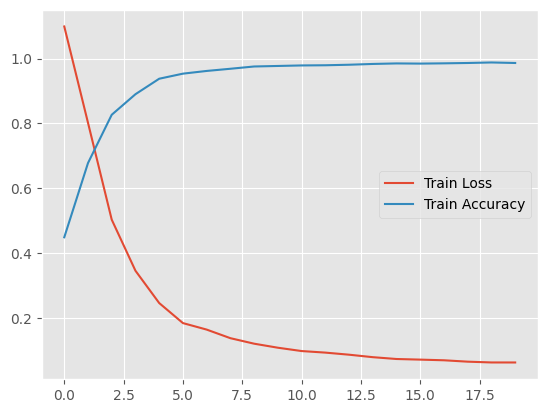

In [37]:
plt.style.use('ggplot')
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.legend()
plt.show()

In [38]:
test_results = model.evaluate(X_test, Y_test_one_hot)
print("Accuracy: ", (test_results[1]*100))

15/15 [==============================] - 1s 42ms/step - loss: 1.6560 - accuracy: 0.6185
Accuracy:  61.853450536727905


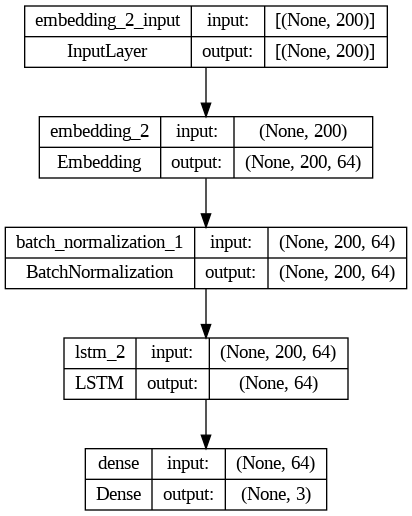

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True)